In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from svetlanna.phase_retrieval_problem import phase_retrieval
from svetlanna import SimulationParameters
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna import LinearOpticalSetup
from svetlanna.units import ureg

In [2]:
torch.set_default_dtype(torch.float64)

In [3]:
# optical setup sizem mm
lx = 8 * ureg.mm
ly = 8 * ureg.mm

# number of nodes
Nx = 800
Ny = 800
# wavelength
lmbd = 660 * ureg.nm

params = SimulationParameters(
    x_size=lx,
    y_size=ly,
    x_nodes=Nx,
    y_nodes=Ny,
    wavelength=lmbd
)


In [4]:
R_in = 0.1 * ureg.mm
R_out = 0.4 * ureg.mm

x = np.linspace(-lx/2, lx/2, Nx)
y = np.linspace(-ly/2, ly/2, Ny)
xv, yv = torch.tensor(np.meshgrid(x, y))
R = torch.sqrt((xv**2 + yv**2))

TARGET_MASK = (R > R_in) & (R < R_out)
TARGET_INTENSITY = TARGET_MASK.float()

/var/folders/gb/c4dxrb656yvf36d5mf8p1ggw0000gn/T/ipykernel_26484/4238545957.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  xv, yv = torch.tensor(np.meshgrid(x, y))


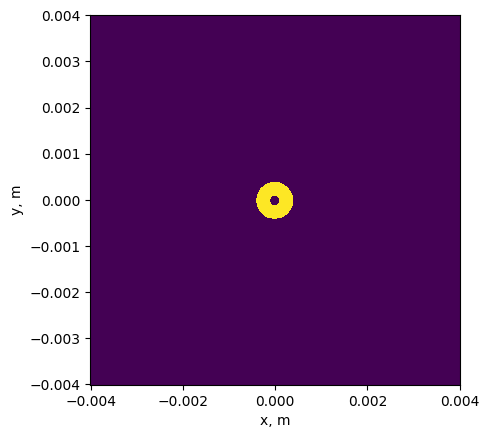

In [5]:
def plot_intensity(intensity):
    plt.pcolor(x, y, intensity)
    plt.gca().set_aspect('equal')
    plt.xlabel('x, m')
    plt.ylabel('y, m')

plot_intensity(TARGET_INTENSITY)

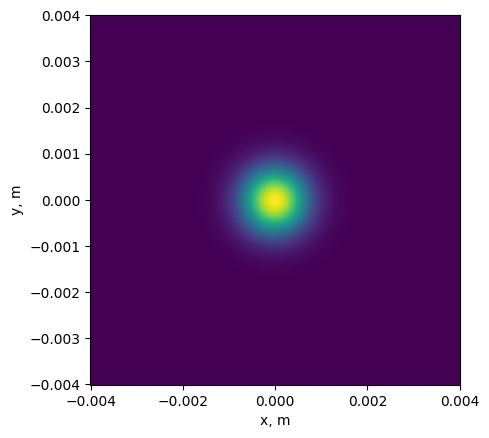

In [6]:
distance = 0 * ureg.mm  # distance between the screen od the lens
w0 = 1 * ureg.mm  # waist radius of the gaussian beam, mm

field_before_lens = Wavefront.gaussian_beam(
    simulation_parameters=params,
    distance=distance,
    waist_radius=w0
)
SOURCE_INTENSITY = field_before_lens.intensity
plot_intensity(SOURCE_INTENSITY)

In [7]:
distance = 40 * ureg.mm  # focal distance of the lens
r = 6 * ureg.mm  # radius of the lens

free_space = elements.FreeSpace(
    simulation_parameters=params,
    distance=torch.tensor(distance),
    method='AS'
)

optical_setup = LinearOpticalSetup([
    free_space,
])

In [8]:
result_hio = phase_retrieval.retrieve_phase(
    source_intensity=SOURCE_INTENSITY,
    optical_setup=optical_setup,
    target_intensity=TARGET_INTENSITY,
    method='GS',
    initial_phase=torch.rand((Nx, Ny)),
    options = {
        'tol': -1,
        'maxiter': 100,
        'constant_factor': float == 0.9,
        'disp': False
    }
)

phase_distribution_hio = result_hio.solution
niter_hio = result_hio.number_of_iterations
error_mass_hio = result_hio.cost_func_evolution

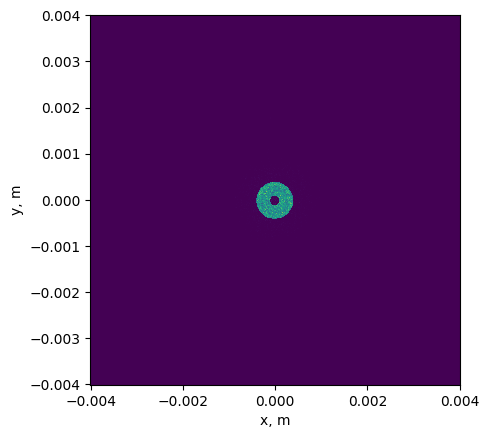

In [9]:
RESULT_INTENSITY = torch.abs(
    optical_setup.forward(
        torch.sqrt(SOURCE_INTENSITY) * torch.exp(1j * phase_distribution_hio )
    )
)**2

plot_intensity(
    RESULT_INTENSITY
)

In [10]:
intensity_target_opt_region = RESULT_INTENSITY[TARGET_MASK]

maxi = torch.max(intensity_target_opt_region)
mini = torch.min(intensity_target_opt_region)
uniformity = 1 - (maxi - mini) / (maxi + mini)
print('Uniformity:' + str(uniformity))

eff = torch.sum(intensity_target_opt_region) / torch.sum(SOURCE_INTENSITY) * 100
print('Power relation:' + str(eff) + '%')

Uniformity:tensor(0.4276)
Power relation:tensor(96.5375)%


Text(0, 0.5, 'y, m')

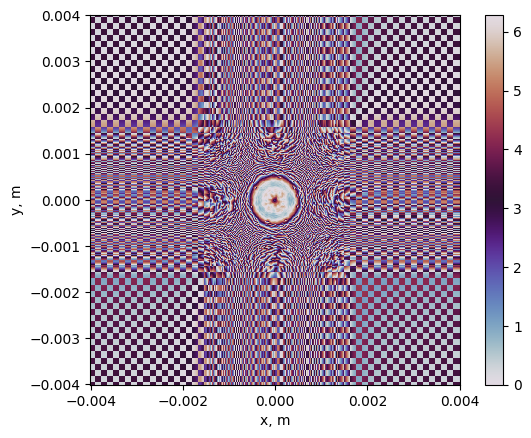

In [15]:
plt.pcolor(
    x,
    y,
    phase_distribution_hio.detach().numpy(),
    cmap='twilight',
    vmax=2*np.pi,
    vmin=0,
)
plt.gca().set_aspect('equal')
plt.colorbar()
plt.xlabel('x, m')
plt.ylabel('y, m')